<a href="https://colab.research.google.com/github/PARULCHUTANIPC/parul/blob/master/Final%20Code%20for%20paper%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install kaggle

from zipfile import ZipFile
import io, cv2, fnmatch, shutil, os, getpass, subprocess, random

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from time import time
from glob import glob
from sklearn.utils import class_weight
from google.colab import files

In [2]:
root_dir = '/content'
download_dir = os.path.join(root_dir,'cats_dogs')
data_dir = os.path.join(download_dir,'data')
train_path = os.path.join(data_dir,'train')
val_path = os.path.join(data_dir,'val')
train_dogs_path = os.path.join(train_path,'dogs')
train_cats_path = os.path.join(train_path,'cats')
val_dogs_path = os.path.join(val_path,'dogs')
val_cats_path = os.path.join(val_path,'cats')

data source - https://www.kaggle.com/c/dogs-vs-cats/data

In [3]:
!pip install kaggle

In [4]:
!mkdir .kaggle
!touch .kaggle/kaggle.json

In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = root_dir
os.chdir(root_dir)
if 'kaggle.json' not in os.listdir(root_dir):downloaded = files.upload()
if 'cats_dogs' in os.listdir(root_dir):shutil.rmtree(download_dir)
os.mkdir(download_dir)
os.chdir(download_dir)
!kaggle competitions download -c dogs-vs-cats
!unzip -q -o train.zip
!unzip -q -o test1.zip

Saving kaggle.json to kaggle.json
 97% 529M/543M [00:02<00:00, 254MB/s]
100% 543M/543M [00:02<00:00, 231MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 79.7MB/s]
100% 271M/271M [00:02<00:00, 77.1MB/s]
100% 271M/271M [00:02<00:00, 101MB/s] 


In [6]:
cat_pattern = '*cat.*.jpg'
dog_pattern = '*dog.*.jpg'

images = glob('/content/cats_dogs/train/*.jpg', recursive=True)
cats = fnmatch.filter(images,cat_pattern)
dogs = fnmatch.filter(images,dog_pattern)

if 'data' not in os.listdir(download_dir):os.mkdir(data_dir)
if 'train' not in os.listdir(data_dir):os.mkdir(train_path)
if 'dogs' not in os.listdir(train_path):os.mkdir(train_dogs_path)
if 'cats' not in os.listdir(train_path):os.mkdir(train_cats_path)
  
if 'val' not in os.listdir(data_dir):os.mkdir(val_path)
if 'dogs' not in os.listdir(val_path):os.mkdir(val_dogs_path)
if 'cats' not in os.listdir(val_path):os.mkdir(val_cats_path)

for file in cats: shutil.copy2(file, train_cats_path)
for file in dogs: shutil.copy2(file, train_dogs_path)
  
  
# split train date into train and validation
train_len = len(os.listdir(train_dogs_path))
val_len = train_len * 0.3
val_dogs = random.sample(os.listdir(train_dogs_path),int(val_len))
val_cats = random.sample(os.listdir(train_cats_path),int(val_len))

for file in val_dogs:
  try: shutil.move(os.path.join(train_dogs_path,file), val_dogs_path)
  except: pass
for file in val_cats:
  try: shutil.move(os.path.join(train_cats_path,file), val_cats_path)
  except: pass
  
print(len(os.listdir(train_cats_path)))
print(len(os.listdir(val_cats_path)))

print(len(os.listdir(train_dogs_path)))
print(len(os.listdir(val_dogs_path)))

print('total train samples ', len(os.listdir(train_cats_path)) + len(os.listdir(train_dogs_path)))
print('total train samples ', len(os.listdir(val_cats_path)) + len(os.listdir(val_dogs_path)))

8750
3750
8750
3750
total train samples  17500
total train samples  7500


In [54]:
print(train_generator.class_indices)

{'cats': 0, 'dogs': 1}


#CNN classifier

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size=64
train_generator = train_datagen.flow_from_directory(
        '/content/cats_dogs/data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary') 

validation_generator = val_datagen.flow_from_directory(
        '/content/cats_dogs/data/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

model = Sequential()
model.add(Conv2D(150, (3, 3), input_shape=( 150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(200, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(215, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(190, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(300))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

start_time = time()
r = model.fit_generator(
        train_generator,
        #steps_per_epoch=18631 // batch_size,
        epochs=40,
        validation_data=validation_generator,
        #validation_steps=10119 // batch_size
        )
model.save_weights('first_try.h5')

print('time taken ',time()-start_time)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
274/274 [==============================] - 193s 533ms/step - loss: 0.8043 - accuracy: 0.5351 - val_loss: 0.6545 - val_accuracy: 0.6269
Epoch 2/40
274/274 [==============================] - 144s 524ms/step - loss: 0.6562 - accuracy: 0.6431 - val_loss: 0.5799 - val_accuracy: 0.6732
Epoch 3/40
274/274 [==============================] - 143s 521ms/step - loss: 0.5688 - accuracy: 0.7099 - val_loss: 0.5002 - val_accuracy: 0.7571
Epoch 4/40
274/274 [==============================] - 144s 525ms/step - loss: 0.5040 - accuracy: 0.7635 - val_loss: 0.4490 - val_accuracy: 0.7971
Epoch 5/40
274/274 [==============================] - 144s 525ms/step - loss: 0.4441 - accuracy: 0.7920 - val_loss: 0.3498 - val_accuracy: 0.8391
Epoch 6/40
274/274 [==============================] - 144s 524ms/step - loss: 0.3944 - accuracy: 0.8242 - val_loss: 0.3517 - val_accuracy: 0.8453
Epoch 7/40
274/274 [==============================] - 142s 519ms/step - loss: 0.3753 - accuracy: 0.8331 - val_loss: 0.3034 -

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 150)     4200      
_________________________________________________________________
activation (Activation)      (None, 148, 148, 150)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 150)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 200)       270200    
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 200)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 200)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 215)       3

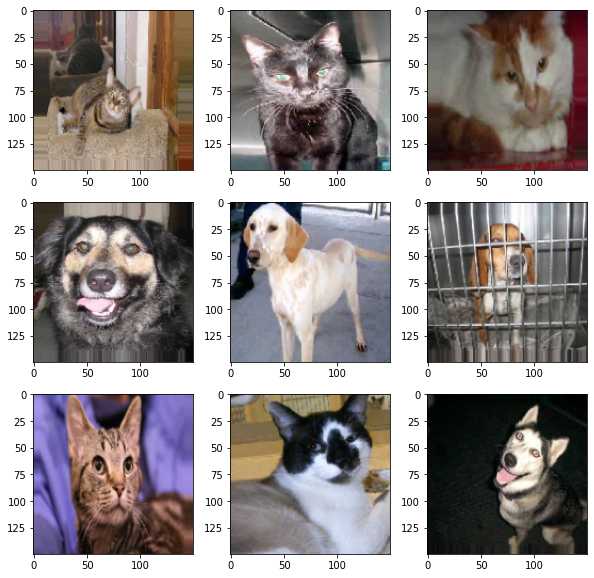

In [141]:
train_images,train_labels = train_generator.next()

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(train_images[i])
  

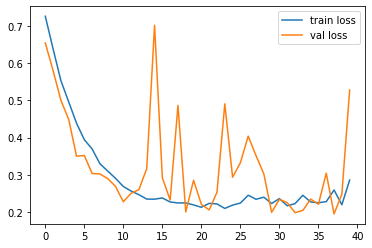

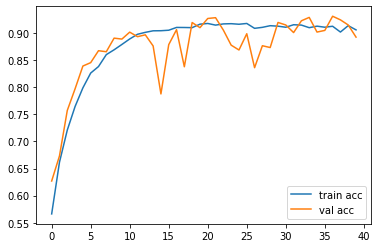

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [118]:

# Part 4 - Making a single prediction

import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/content/cat4.jpg', target_size = (150,150))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

In [119]:
result

array([[0.28872067]], dtype=float32)

In [120]:
if result[0]<0.5:
    print("The image classified is cat")
else:
    print("The image classified is dog")

The image classified is cat


In [113]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

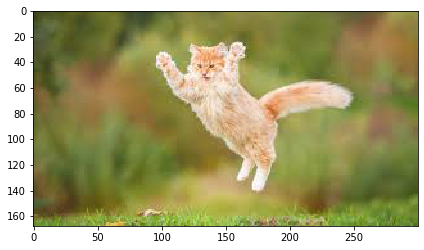

The image classified is cat


In [117]:
  imshow("/content/cat4.jpg")
  if result[0]<0.5:
    print("The image classified is cat")
else:
    print("The image classified is dog")